# Анализ влияния близости школ на пешеходный трафик и средний чек

Цель: сравнить **пешеходный трафик** и средний чек магазинов, которые находятся **рядом со школой** (есть школы в радиусе 300 м) и **не рядом со школой**, при фиксированных остальных условиях.

Работаем с файлом:
- `Х5_with_region_index_2024_population_patched_with_flags.xlsx`

Используемые поля:
- `Населенный пункт`
- `Регион`
- `Школы (300 м)` — количество школ в радиусе 300 м
- `Трафик пеший, в час` — пешеходный трафик магазина
- `Средний чек`
- `Торговая площадь, категориальный` — размер магазина ("Маленький", "Средний", "Большой", "Очень большой")
- `Индекс_РИА_2024` — индекс развития территории
- `is_season` — флаг сезонности (1 — учебный сезон)
- `traffic_flag` — флаг корректности/достоверности трафика (1 — данные ок)

## Логика расчёта

1. **Фильтруем по индексу развития**: берём только строки, где `40 < Индекс_РИА_2024 < 70`.
2. **Фильтруем по сезонности и качеству трафика**:
   - `is_season == 1` (учебное время, не лето);
   - `traffic_flag == 1`.
3. **Фильтруем по пешеходному трафику**: оставляем только магазины, где
   - `Трафик пеший, в час > 0`.
   
   Автомобильный трафик **полностью игнорируем**.

4. **Классифицируем магазины по размеру** по полю `Торговая площадь, категориальный`:
   - `Маленький` → группа `small`;
   - `Средний` → группа `medium`;
   - `Большой` и `Очень большой` → группа `large_plus`.
5. **Формируем признак наличия школы**:
   - `has_school = (Школы (300 м) > 0)`.
6. Для **каждого населённого пункта и региона** отдельно:
   - делим магазины на две группы:
     - рядом со школой (`has_school = True`),
     - не рядом со школой (`has_school = False`);
   - и внутри каждой группы считаем по размеру магазина (`small`, `medium`, `large_plus`):
     - средний **пешеходный** трафик (`mean(Трафик пеший, в час)`),
     - средний чек (`mean(Средний чек)`).
7. Для каждой комбинации (НП, регион, размер) считаем **отношения**:
   - `traffic_ratio_* = mean_ped_traffic(есть школа) / mean_ped_traffic(нет школы)`;
   - `check_ratio_* = mean_check(есть школа) / mean_check(нет школы)`.
8. Собираем финальную таблицу:
   - `Населенный пункт`, `Регион`,
   - 6 чисел:
     - `traffic_ratio_small`, `check_ratio_small`,
     - `traffic_ratio_medium`, `check_ratio_medium`,
     - `traffic_ratio_large_plus`, `check_ratio_large_plus`.


In [1]:
import pandas as pd
from pathlib import Path

# Путь к исходному файлу 
input_path = Path("Х5_with_region_index_2024_population_patched_with_flags.xlsx")

# Загрузка данных
df = pd.read_excel(input_path)

print("Размер исходного датафрейма:", df.shape)
df.head()

Размер исходного датафрейма: (256711, 21)


,new_id,Месяц,Трафик,Средний чек,"Дата открытия, категориальный","Торговая площадь, категориальный",Населенный пункт,Регион,Численность населения,Количество домохозяйств,...,"Трафик авто, в час","Маркетплейсы, доставки, постаматы (100 м)",Медицинские уч. и аптеки (300 м),Школы (300 м),Остановки (300 м),Продуктовые магазины (500 м),Пятерочки (500 м),Индекс_РИА_2024,traffic_flag,is_season
0,0,10,59662,976.170936,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
1,0,5,56674,1025.462154,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
2,0,1,51488,1158.150890,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
3,3594,7,68039,1119.028697,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1
4,3594,6,64878,1112.584778,Средний по возрасту,Средний,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,3827,768,...,406.0,5,1,0,0,1,0,61.98,1,1


## Шаг 1. Фильтрация по индексу развития, сезонности и качеству трафика

- Оставляем только строки, где `30 < Индекс_РИА_2024 < 70`.
- Берём только `is_season == 1` (учебное время).
- Берём только `traffic_flag == 1`.
- Фильтруем по ненулевому **пешеходному** трафику.
- Автомобильный трафик не используем.


In [2]:
# Названия ключевых столбцов
col_index = "Индекс_РИА_2024"
col_is_season = "is_season"
col_traffic_flag = "traffic_flag"
col_pedestrian =  "Трафик пеший, в час" # "Трафик" #

# Приводим индекс к числу на всякий случай
df[col_index] = pd.to_numeric(df[col_index], errors="coerce")

# Фильтры по условиям
mask_season = df[col_is_season] == 0
mask_traffic_flag = df[col_traffic_flag] == 1
mask_pedestrian = df[col_pedestrian] > 0

# Автотрафик теперь не учитываем ни в фильтре, ни в метриках (не факт)
base_df = df[mask_season & mask_traffic_flag & mask_pedestrian].copy()

print("Размер после фильтрации:", base_df.shape)
base_df.head()

Размер после фильтрации: (178677, 21)


,new_id,Месяц,Трафик,Средний чек,"Дата открытия, категориальный","Торговая площадь, категориальный",Населенный пункт,Регион,Численность населения,Количество домохозяйств,...,"Трафик авто, в час","Маркетплейсы, доставки, постаматы (100 м)",Медицинские уч. и аптеки (300 м),Школы (300 м),Остановки (300 м),Продуктовые магазины (500 м),Пятерочки (500 м),Индекс_РИА_2024,traffic_flag,is_season
0,0,10,59662,976.170936,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
1,0,5,56674,1025.462154,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
2,0,1,51488,1158.150890,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
5,0,12,59476,1031.000127,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0
6,0,9,55856,1035.065767,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.4,0,0,0,0,0,0,76.58,1,0


## Шаг 2. Признак наличия школы и группы по размеру магазина

1. Формируем флаг `has_school`:
   - `True`, если `Школы (300 м) > 0`;
   - `False`, если `Школы (300 м) == 0`.
2. Переводим `Торговая площадь, категориальный` в три группы:
   - `Маленький` → `small`;
   - `Средний` → `medium`;
   - `Большой` и `Очень большой` → `large_plus`.


In [4]:
col_schools = "Школы (300 м)"
col_size_cat = "Торговая площадь, категориальный"

# Признак наличия школ
base_df[col_schools] = pd.to_numeric(base_df[col_schools], errors="coerce").fillna(0)
base_df["has_school"] = base_df[col_schools] > 0

# Маппинг категорий площади в 3 группы
size_map = {
    "Маленький": "small",
    "Средний": "medium",
    "Большой": "large_plus",
    "Очень большой": "large_plus",
}

base_df["size_group"] = base_df[col_size_cat].map(size_map)

# Оставляем только строки с валидными size_group
base_df = base_df[base_df["size_group"].notna()].copy()

print("Размер после добавления признаков и фильтрации по size_group:", base_df.shape)
base_df[["Населенный пункт", "Регион", col_size_cat, "size_group", col_schools, "has_school"]].head()



Размер после добавления признаков и фильтрации по size_group: (178677, 23)


,Населенный пункт,Регион,"Торговая площадь, категориальный",size_group,Школы (300 м),has_school
0,Абинск г,Краснодарский край,Средний,medium,0,False
1,Абинск г,Краснодарский край,Средний,medium,0,False
2,Абинск г,Краснодарский край,Средний,medium,0,False
5,Абинск г,Краснодарский край,Средний,medium,0,False
6,Абинск г,Краснодарский край,Средний,medium,0,False


## Шаг 3. Расчёт средних значений по группам (школа / нет школы, размер)

- Для каждого сочетания:
  - `Населенный пункт`,
  - `Регион`,
  - `size_group`,
  - `has_school` (есть / нет школ рядом)
  
считаем:
- средний **пешеходный** трафик (`mean(Трафик пеший, в час)`),
- средний чек (`mean(Средний чек)`).


In [5]:
col_np = "Населенный пункт"
col_region = "Регион"
col_traffic = col_pedestrian  # Используем только пешеходный трафик
col_check = "Средний чек"

# На всякий случай приводим метрики к числам
base_df[col_traffic] = pd.to_numeric(base_df[col_traffic], errors="coerce")
base_df[col_check] = pd.to_numeric(base_df[col_check], errors="coerce")

group_cols = [col_np, col_region, "size_group", "has_school", col_index]

agg_df = (
    base_df
    .groupby(group_cols)
    .agg(
        mean_traffic=(col_traffic, "mean"),
        mean_check=(col_check, "mean"),
        count=(col_traffic, "size"),
    )
    .reset_index()
)

print("Размер агрегированного датафрейма:", agg_df.shape)
agg_df.head()

Размер агрегированного датафрейма: (5537, 8)


,Населенный пункт,Регион,size_group,has_school,Индекс_РИА_2024,mean_traffic,mean_check,count
0,"1-го отделения совхоза ""Масловский"" п",Воронежская обл,medium,False,61.98,89.857143,1062.576180,9
1,1-я Моква д,Курская обл,medium,False,50.02,86.555556,1311.874036,9
2,1-я Моква д,Курская обл,medium,True,50.02,95.666667,590.254950,9
3,Абадзехская ст-ца,Адыгея Респ,small,False,35.68,71.666667,809.205442,9
4,Абаза г,Хакасия Респ,medium,False,31.09,321.846154,851.943655,9


In [6]:
has_school_in_city = agg_df[[col_np, "has_school"]].groupby([col_np])["has_school"].sum().reset_index()
has_school_in_city[has_school_in_city['has_school'] > 0]

,Населенный пункт,has_school
1,1-я Моква д,1
4,Абакан г,2
8,Абинск г,2
16,Агрыз г,2
18,Адыгейск г,1
...,...,...
2691,Яхрома г,1
2694,Яя пгт,1
2700,имени 9 Января с,1
2704,"опытного хоз-ва ""Ермолино"" п",1


In [7]:
mask_index_m_70 = (agg_df[col_index] > 70)
mask_index_m_40_70 = (agg_df[col_index] < 70) & (agg_df[col_index] > 40)
mask_index_m_40 = (agg_df[col_index] < 40)
df_70 = agg_df[mask_index_m_70]
df_40_70 = agg_df[mask_index_m_40_70]
df_40 = agg_df[mask_index_m_40]
print(df_70.shape, df_40_70.shape,df_40.shape )

(1704, 8) (3235, 8) (598, 8)


## Шаг 4. Расчёт отношений (есть школа / нет школы) по каждой группе размера

Для каждого населённого пункта и размера (`small`, `medium`, `large_plus`):

- считаем:
  - `traffic_ratio_* = mean_ped_traffic(есть школа) / mean_ped_traffic(нет школы)`;
  - `check_ratio_* = mean_check(есть школа) / mean_check(нет школы)`.

Если для какой-то комбинации нет данных либо для магазинов со школами, либо без школ, отношение будет `NaN`.


Рассчитаем средний чек по площадям в разных индекс-группах

In [8]:
ranges = [
    ("x<40", df_40),
    ("40<x<70", df_40_70),
    ("x>70", df_70),
]

rows = []
size_labels = ['small','medium','large_plus']

for label, df_part in ranges:
    for has_school in (0, 1):
        sub = df_part[df_part['has_school'] == has_school]
        small_mean = sub.loc[sub['size_group']=='small','mean_check'].mean()
        med_mean   = sub.loc[sub['size_group']=='medium','mean_check'].mean()
        large_mean = sub.loc[sub['size_group']=='large_plus','mean_check'].mean()

        rows.append({
            'index': label,
            'has_school': has_school,
            'small': small_mean,
            'medium': med_mean,
            'large_plus': large_mean
        })

df_mean_check = pd.DataFrame(rows)
df_mean_check = df_mean_check.set_index(['index','has_school']).sort_index()
df_mean_check

small       medium   large_plus
index   has_school                                      
40<x<70 0           776.988368   946.179972  1101.739047
        1           749.020294   897.655042  1078.656796
x<40    0           791.654408   884.286521  1035.493333
        1           780.097087   865.268908  1037.984181
x>70    0           880.104402  1007.783907  1314.589627
        1           838.903155   953.188227  1286.217122

Рассчитаем средний трафик по площадям в разных индекс-группах

In [9]:
rows = []
labels = ["x<40", "40<x<70", "x>70"]

for label, df in zip(labels, [df_70, df_40_70, df_40]):
    for hs in [0, 1]:
        sub = df[df["has_school"] == hs]

        small_mean  = sub[sub["size_group"] == "small"]["mean_traffic"].mean()
        med_mean    = sub[sub["size_group"] == "medium"]["mean_traffic"].mean()
        large_mean  = sub[sub["size_group"] == "large_plus"]["mean_traffic"].mean()

        rows.append({
            "index": label,
            "has_school": hs,
            "small": small_mean,
            "medium": med_mean,
            "large_plus": large_mean
        })

df_mean_traffic = pd.DataFrame(rows)
df_mean_traffic.set_index(["index", "has_school"], inplace=True)
df_mean_traffic


small      medium  large_plus
index   has_school                                    
x<40    0           112.076863  110.184044  123.755192
        1           119.929539  124.901199  136.527234
40<x<70 0           116.348529  113.190132  130.417619
        1           135.780910  123.684806  141.903544
x>70    0           125.777092  118.896038  141.851475
        1           129.779799  134.482203  146.686183

In [10]:
df_mean_traffic.to_excel("df_mean_traffic_pesh_season.xlsx")
df_mean_check.to_excel("df_mean_check_season.xlsx")

Теперь все таки рассчитаем отношения

In [13]:
import numpy as np

ranges = [
    ("x<40", df_40),
    ("40<x<70", df_40_70),
    ("x>70", df_70),
]

records = []

for range_label, df_part in ranges:
    grouped = df_part.groupby([col_np, col_region, 'size_group'])

    for (np_name, region_name, size_group), sub in grouped:
        with_school = sub[sub['has_school'] == True]
        without_school = sub[sub['has_school'] == False]

        if with_school.empty or without_school.empty:
            traffic_ratio = np.nan
            check_ratio = np.nan
        else:
            mean_traf_school = with_school['mean_traffic'].mean()
            mean_traf_no_school = without_school['mean_traffic'].mean()
            mean_check_school = with_school['mean_check'].mean()
            mean_check_no_school = without_school['mean_check'].mean()

            traffic_ratio = mean_traf_school / mean_traf_no_school if mean_traf_no_school else np.nan
            check_ratio = mean_check_school / mean_check_no_school if mean_check_no_school else np.nan

        records.append({
            'range': range_label,
            col_np: np_name,
            col_region: region_name,
            'size_group': size_group,
            'traffic_ratio': traffic_ratio,
            'check_ratio': check_ratio
        })

ratio_df = pd.DataFrame.from_records(records)

ratio_clean = ratio_df.dropna(subset=['traffic_ratio', 'check_ratio'], how='all')

agg = ratio_clean.groupby(['range', 'size_group']).agg(
    mean_traffic_ratio=('traffic_ratio', 'mean'),
    mean_check_ratio=('check_ratio', 'mean'),
).reset_index()

agg_long = agg.copy()
agg_long['traffic_col'] = agg_long['size_group'] + '_traffic_ratio'
agg_long['check_col'] = agg_long['size_group'] + '_check_ratio'

traffic_pivot = agg_long.pivot(index='range', columns='traffic_col', values='mean_traffic_ratio')
check_pivot = agg_long.pivot(index='range', columns='check_col', values='mean_check_ratio')

df_result = pd.concat([traffic_pivot, check_pivot], axis=1).reset_index().sort_values('range')

desired_order = []
for size in ['small', 'medium', 'large_plus']:
    desired_order.append(f'{size}_traffic_ratio')
for size in ['small', 'medium', 'large_plus']:
    desired_order.append(f'{size}_check_ratio')

cols = ['range'] + [c for c in desired_order if c in df_result.columns]
df_result = df_result[cols]



In [14]:
df_result.to_excel('df_result_ratios_by_range_and_size_pesh_season.xlsx', index=False)
ratio_df.to_excel('ratio_df_detailed_pesh_season.xlsx', index=False)

Теперь проведем тестирование для всего этого

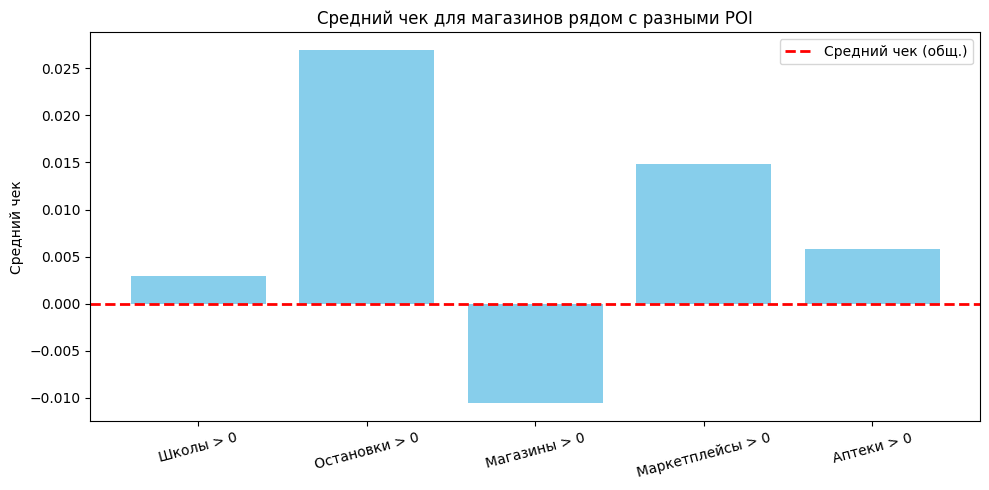

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Укажи названия столбцов, где хранятся количества POI
col_check = 'Средний чек'
col_schools = 'Школы (300 м)'
col_stops = 'Остановки (300 м)'
col_shops = 'Продуктовые магазины (500 м)'
col_marketplaces = 'Маркетплейсы, доставки, постаматы (100 м)'
col_med = 'Медицинские уч. и аптеки (300 м)'

# Создаем флаги "есть ли POI"
df['has_school'] = df[col_schools] > 0
df['has_stop'] = df[col_stops] > 0
df['has_shop'] = df[col_shops] > 0
df['has_marketplace'] = df[col_marketplaces] > 0
df['has_med'] = df[col_med] > 0

# Средний чек по всей выборке
overall_mean = df[col_check].mean()
# Группы для графика
groups = {
    "Школы > 0": df[df['has_school']][col_check].mean() / overall_mean -1 ,
    "Остановки > 0": df[df['has_stop']][col_check].mean() / overall_mean -1 ,
    "Магазины > 0": df[df['has_shop']][col_check].mean() /overall_mean -1 ,
    "Маркетплейсы > 0": df[df['has_marketplace']][col_check].mean() /overall_mean -1 ,
    "Аптеки > 0": df[df['has_med']][col_check].mean() /overall_mean -1 ,
}


# Построение графика
plt.figure(figsize=(10, 5))

plt.bar(groups.keys(), groups.values(), color='skyblue')

# Линия среднего
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Средний чек (общ.)')

plt.title('Средний чек для магазинов рядом с разными POI')
plt.ylabel('Средний чек')
plt.xticks(rotation=15)
plt.legend()

plt.tight_layout()
plt.show()


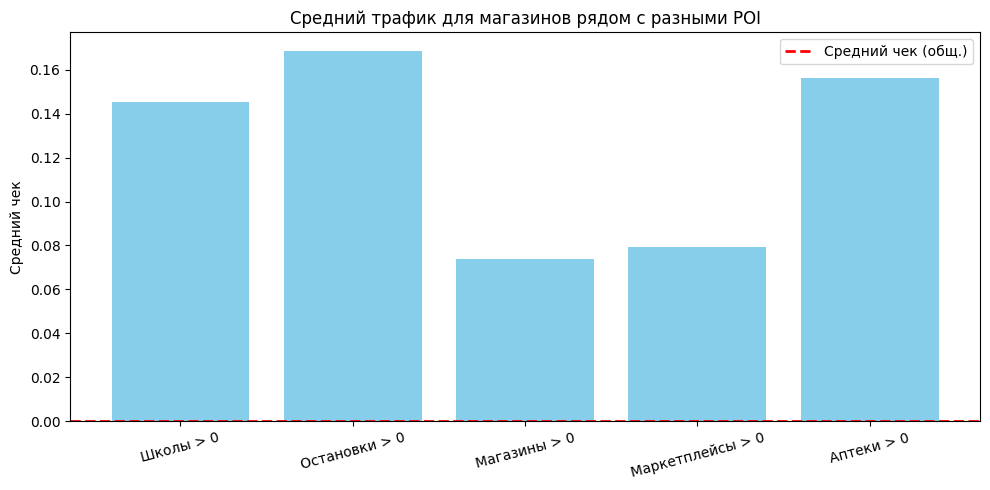

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Укажи названия столбцов, где хранятся количества POI
col_check = 'Средний чек'
col_trafic = 'Трафик пеший, в час'
col_schools = 'Школы (300 м)'
col_stops = 'Остановки (300 м)'
col_shops = 'Продуктовые магазины (500 м)'
col_marketplaces = 'Маркетплейсы, доставки, постаматы (100 м)'
col_med = 'Медицинские уч. и аптеки (300 м)'

# Создаем флаги "есть ли POI"
df['has_school'] = df[col_schools] > 0
df['has_stop'] = df[col_stops] > 0
df['has_shop'] = df[col_shops] > 0
df['has_marketplace'] = df[col_marketplaces] > 0
df['has_med'] = df[col_med] > 0

# Средний чек по всей выборке
overall_mean = df[col_trafic].mean()
# Группы для графика
groups = {
    "Школы > 0": df[df['has_school']][col_trafic].mean() / overall_mean -1 ,
    "Остановки > 0": df[df['has_stop']][col_trafic].mean() / overall_mean -1 ,
    "Магазины > 0": df[df['has_shop']][col_trafic].mean() /overall_mean -1 ,
    "Маркетплейсы > 0": df[df['has_marketplace']][col_trafic].mean() /overall_mean -1 ,
    "Аптеки > 0": df[df['has_med']][col_trafic].mean() /overall_mean -1 ,
}


# Построение графика
plt.figure(figsize=(10, 5))

plt.bar(groups.keys(), groups.values(), color='skyblue')

# Линия среднего
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Средний чек (общ.)')

plt.title('Средний трафик для магазинов рядом с разными POI')
plt.ylabel('Средний чек')
plt.xticks(rotation=15)
plt.legend()

plt.tight_layout()
plt.show()


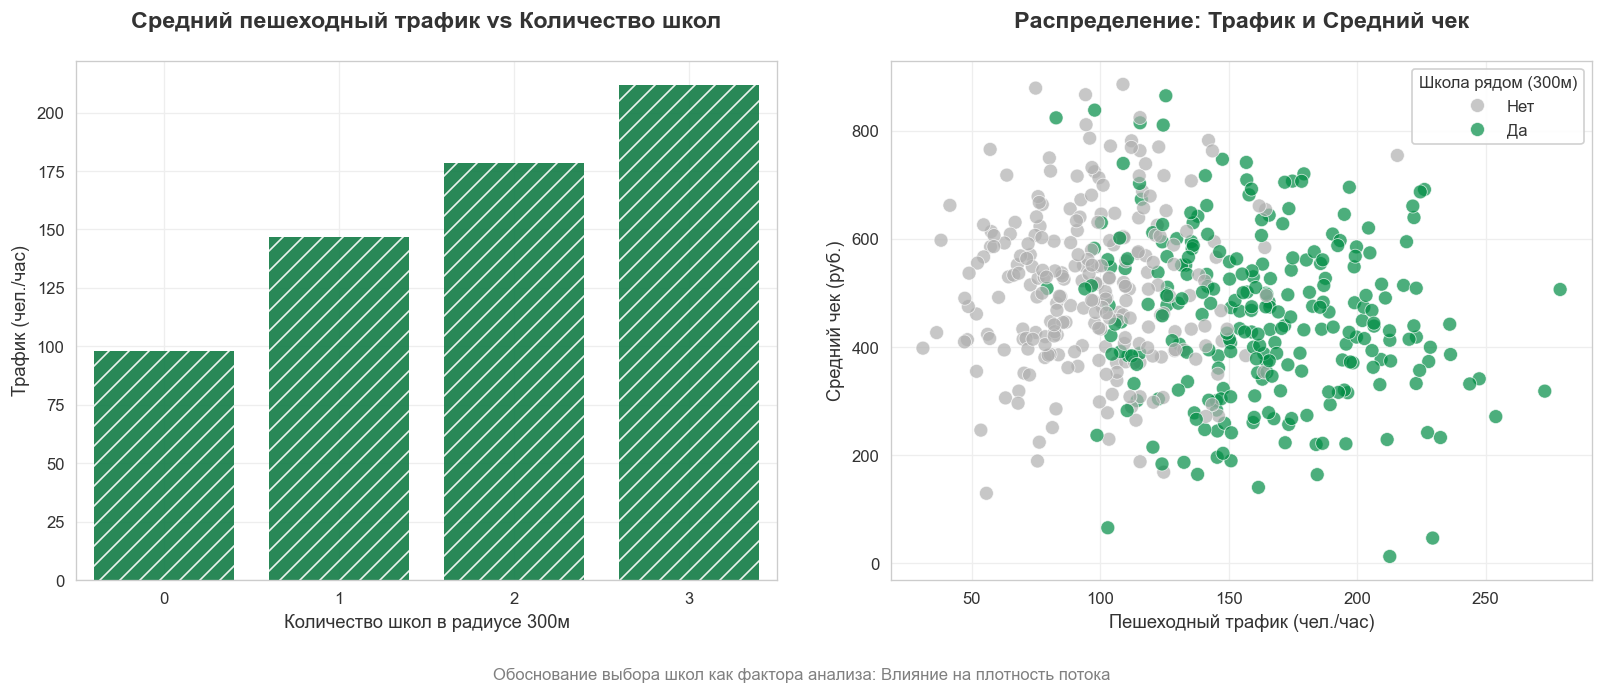

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# -------------------------------------------------------------------------
# 1. ГЕНЕРАЦИЯ ДЕМО-ДАННЫХ (Чтобы код работал сразу)
# В реальной работе этот блок нужно заменить на загрузку вашего df
# -------------------------------------------------------------------------
np.random.seed(42)
n = 500
data = {
    'new_id': range(n),
    'Трафик пеший, в час': np.random.normal(100, 30, n),
    'Средний чек': np.random.normal(500, 150, n),
    'Школы (300 м)': np.random.choice([0, 1, 2, 3], n, p=[0.5, 0.3, 0.15, 0.05])
}
df = pd.DataFrame(data)

# Добавляем искусственную зависимость для красоты графиков (школы повышают трафик)
df['Трафик пеший, в час'] += df['Школы (300 м)'] * 40 
# Немного снижаем чек у школ (дети покупают мелочь), но трафик выше
df['Средний чек'] -= df['Школы (300 м)'] * 30 

# Категория для раскраски
df['Есть школа'] = df['Школы (300 м)'].apply(lambda x: 'Да' if x > 0 else 'Нет')

# -------------------------------------------------------------------------
# 2. НАСТРОЙКА ВИЗУАЛЬНОГО СТИЛЯ (Под Пятёрочку)
# -------------------------------------------------------------------------
# Основные цвета из слайдов
pyaterochka_green = '#008C44'  # Насыщенный зеленый
light_green = '#E6F4EA'        # Светлый фон (подложка)
accent_red = '#E21E26'         # Акцент (если нужен)
dark_text = '#333333'

# Настройка глобальных параметров
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'text.color': dark_text,
    'axes.labelcolor': dark_text,
    'xtick.color': dark_text,
    'ytick.color': dark_text,
    'axes.edgecolor': '#CCCCCC',
    'grid.color': '#EEEEEE',
    'figure.dpi': 120
})

# -------------------------------------------------------------------------
# 3. ПОСТРОЕНИЕ ГРАФИКОВ
# -------------------------------------------------------------------------

# Создаем фигуру с двумя графиками рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white') # Белый фон для вставки на слайд-шаблон

# === ГРАФИК 1: Влияние школ на пешеходный трафик ===
# Обоснование: "Школы обеспечивают плотный поток людей"

# Агрегируем данные
traffic_by_school = df.groupby('Школы (300 м)')['Трафик пеший, в час'].mean().reset_index()

sns.barplot(
    data=traffic_by_school,
    x='Школы (300 м)',
    y='Трафик пеший, в час',
    ax=axes[0],
    color=pyaterochka_green,
    alpha=0.9,
    edgecolor=pyaterochka_green
)

# Добавляем узор (штриховку) на столбцы, чтобы перекликалось с дизайном слайдов
for patch in axes[0].patches:
    patch.set_hatch('//')
    patch.set_edgecolor('white') # Цвет штриховки
    patch.set_linewidth(0)

axes[0].set_title('Средний пешеходный трафик vs Количество школ', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Трафик (чел./час)', fontsize=11)
axes[0].set_xlabel('Количество школ в радиусе 300м', fontsize=11)
axes[0].grid(axis='x') # Убираем вертикальную сетку для чистоты

# === ГРАФИК 2: Кластеризация магазинов (Трафик vs Чек) ===
# Обоснование: "Магазины у школ формируют кластер High Traffic / Medium Check"

sns.scatterplot(
    data=df,
    x='Трафик пеший, в час',
    y='Средний чек',
    hue='Есть школа',
    palette={'Да': pyaterochka_green, 'Нет': '#B0B0B0'}, # Зеленый - есть школа, Серый - нет
    alpha=0.7,
    s=70,
    ax=axes[1],
    edgecolor='white',
    linewidth=0.5
)

axes[1].set_title('Распределение: Трафик и Средний чек', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Пешеходный трафик (чел./час)', fontsize=11)
axes[1].set_ylabel('Средний чек (руб.)', fontsize=11)
axes[1].legend(title='Школа рядом (300м)', title_fontsize=10, loc='upper right', frameon=True, framealpha=0.9)

# -------------------------------------------------------------------------
# 4. ФИНАЛЬНЫЕ ШТРИХИ И СОХРАНЕНИЕ
# -------------------------------------------------------------------------
plt.tight_layout(pad=3.0)


# Добавляем общий заголовок для понимания контекста (можно убрать при вставке)
plt.suptitle('Обоснование выбора школ как фактора анализа: Влияние на плотность потока', 
             fontsize=10, color='gray', y=0.02)

plt.show()


In [6]:
df[df['traffic_flag'] > 0].groupby("new_id").agg({'traffic_flag': 'count', 'new_id': 'first'})

,traffic_flag,new_id
new_id,,
0,12,0
1,12,1
2,12,2
3,12,3
4,12,4
...,...,...
21738,5,21738
21739,5,21739
21740,6,21740


In [18]:
base_df

,new_id,Месяц,Трафик,Средний чек,"Дата открытия, категориальный","Торговая площадь, категориальный",Населенный пункт,Регион,Численность населения,Количество домохозяйств,...,"Трафик авто, в час","Маркетплейсы, доставки, постаматы (100 м)",Медицинские уч. и аптеки (300 м),Школы (300 м),Остановки (300 м),Продуктовые магазины (500 м),Пятерочки (500 м),Индекс_РИА_2024,traffic_flag,is_season
0,0,10,59662,976.170936,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.400000,0,0,0,0,0,0,76.58,1,0
1,0,5,56674,1025.462154,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.400000,0,0,0,0,0,0,76.58,1,0
2,0,1,51488,1158.150890,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.400000,0,0,0,0,0,0,76.58,1,0
5,0,12,59476,1031.000127,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.400000,0,0,0,0,0,0,76.58,1,0
6,0,9,55856,1035.065767,Средний по возрасту,Средний,Абинск г,Краснодарский край,38231,728,...,146.400000,0,0,0,0,0,0,76.58,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256705,21741,12,52388,1183.302760,Новый,Большой,Преображенская ст-ца,Волгоградская обл,4889,275,...,223.333333,0,1,0,0,2,1,53.66,1,0
256706,21742,10,51676,1167.101083,Новый,Средний,Октябрьский рп,Волгоградская обл,6071,262,...,243.333333,1,1,0,0,1,0,53.66,1,0
256707,21742,11,51516,1252.914118,Новый,Средний,Октябрьский рп,Волгоградская обл,6071,262,...,243.333333,1,1,0,0,1,0,53.66,1,0
256708,21742,9,49593,1130.823998,Новый,Средний,Октябрьский рп,Волгоградская обл,6071,262,...,243.333333,1,1,0,0,1,0,53.66,1,0


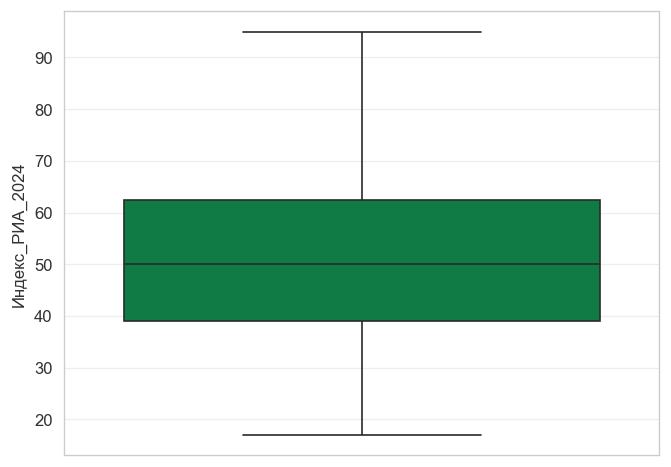

In [26]:
import seaborn as sns
# Основные цвета из слайдов
pyaterochka_green = '#008C44'  # Насыщенный зеленый
light_green = '#E6F4EA'        # Светлый фон (подложка)
accent_red = '#E21E26'         # Акцент (если нужен)
dark_text = '#333333'

# Настройка глобальных параметров
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans'],
    'text.color': dark_text,
    'axes.labelcolor': dark_text,
    'xtick.color': dark_text,
    'ytick.color': dark_text,
    'axes.edgecolor': '#CCCCCC',
    'grid.color': '#EEEEEE',
    'figure.dpi': 120
})
dfi = base_df[['Регион', 'Индекс_РИА_2024']].groupby('Регион').agg('mean').reset_index()
dfi['Индекс_РИА_2024'] = dfi['Индекс_РИА_2024'].map(round)
sns.boxplot(data=dfi, y='Индекс_РИА_2024',
    color=pyaterochka_green,)
plt.xticks(rotation=90, ha='right')
plt.show()